<a href="https://colab.research.google.com/github/nematatu/Colab-Python/blob/master/kasoon_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install -q bing_image_downloader
!pip install -q google-cloud-vision
!pip install -q tensorflow
!pip install -q Pillow

In [61]:
from bing_image_downloader import downloader
from google.cloud import vision
import google.cloud.vision_v1.types as types
from PIL import Image as PILImage
from PIL import ImageOps
import os
import random
import shutil
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
from IPython.display import Image,display_jpeg

In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!readlink -f drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json

/content/drive/MyDrive/Colab Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json


In [64]:
google_auth_path='/content/drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json'


In [65]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ='/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json'


In [66]:
from bing_image_downloader import downloader
query_string = input("input:")

downloader.download(query_string,output_dir=r'./img',adult_filter_off=False,timeout=120,verbose= True)

input:伊織もえ
[%] Downloading Images to /content/img/伊織もえ


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://i.pinimg.com/originals/ef/39/db/ef39db5d729414bc7c59dffcf7e4171d.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://pbs.twimg.com/media/Dgi78bGV4AEJ400.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://i.pinimg.com/originals/51/25/ff/5125ff0921d032508862c07d528dc138.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://i.pinimg.com/originals/0f/c3/ff/0fc3ff74e2faa41d6c5ac00f291b9e15.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://64.media.tumblr.com/4a4890339366df2add14bfa4d55788fa/61fb090ea2eb0603-f6/s1280x1920/5bcd9917b11fdc5e38dc2345b4e99ca2e3570e55.jpg
[Error]Invalid image, not saving https://64.media.tumblr.com/4a4890339366df2add14bfa4d55788fa/61fb090ea2eb0603-f6/s1280x1920/5bcd9917b11fdc5e38dc2345b4e99ca2e3570e55.jpg

[!] Issue getting: https://64.media.tumblr.com/4a48903393

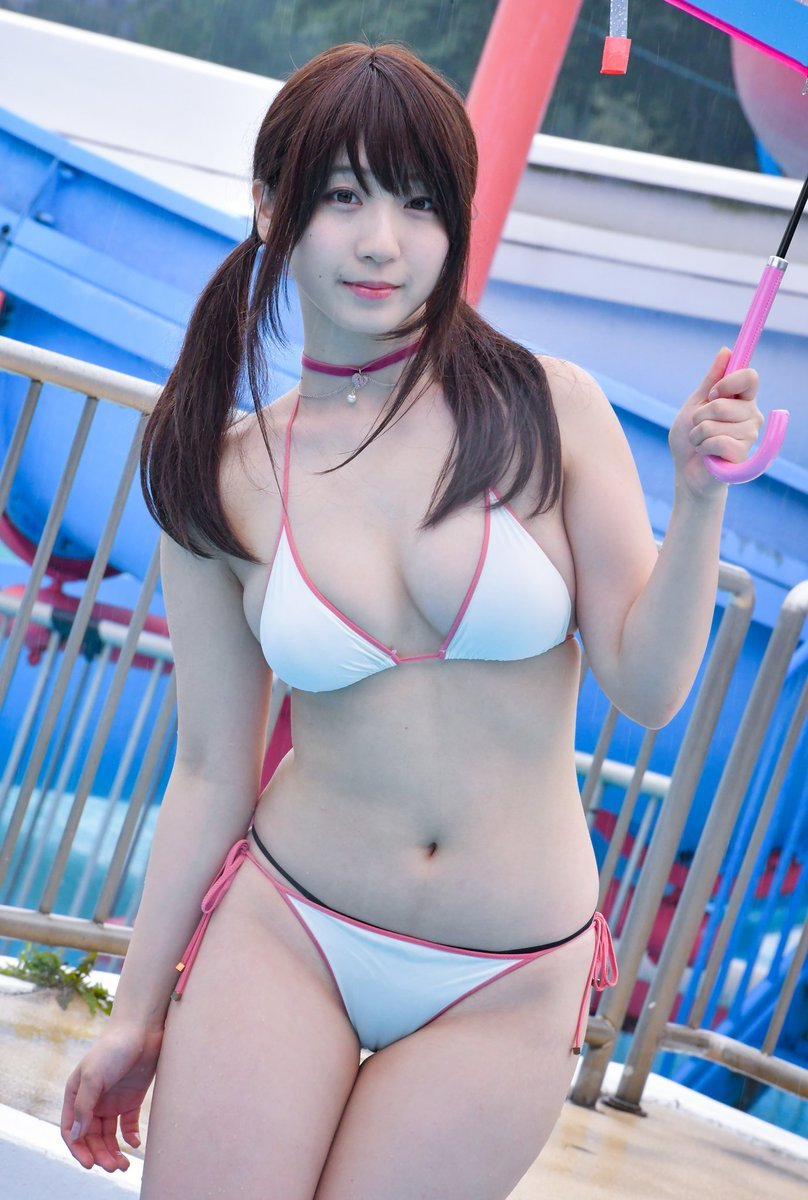

In [67]:
display_jpeg(Image(f'img/{query_string}/Image_10.jpg'))

In [68]:
#def: 顔の検知
def detect_face(image_path):
    client=vision.ImageAnnotatorClient()
    #コードブロックが終わったら自動でfileが閉じる
    #メモリの効率化
    #引数で取ったiamge_pathを'rb'バイナリファイルを読み込む
    with open(image_path, 'rb') as file:
        #読み込んだバイナリファイルを画像形式に変換している
        image=types.Image(content=file.read())
        #GCV APIのface_detection()を使って画像内の顔を検出する
        #そのうち、顔の情報を含むface_annotationsオブジェクトを返す
        annotations=client.face_detection(image=image).face_annotations

    face_boxes=[]

    for annotation in annotations:
        #annotation(顔の情報)の境界ボックス(bounding_poly)の座標情報(vertices)を取得
        #リスト内包表記で、うちx座標のみをリストに格納
        x_s=[vertex.x for vertex in annotation.bounding_poly.vertices]
        y_s=[vertex.y for vertex in annotation.bounding_poly.vertices]
        face_boxes.append((min(x_s),min(y_s),max(x_s),max(y_s)))
    return face_boxes

In [69]:
#def: データセットの分割
train_dir_path='./ds/train'
test_dir_path='./ds/test'

def split_dataset(image_dir_path):
  file_list=os.listdir(image_dir_path)
  random.shuffle(file_list)

  dir_name=image_dir_path.split('/')[-1]
  train_size=int(len(file_list)*0.8)
  if not os.path.exists('./ds'):
    os.mkdir('./ds')
    os.mkdir(train_dir_path)
    os.mkdir(test_dir_path)
    os.mkdir(os.path.join(test_dir_path,dir_name))
    os.mkdir(os.path.join(train_dir_path,dir_name))
  for i, file in enumerate(file_list):
        if i < train_size:
            shutil.copy(os.path.join(image_dir_path, file), os.path.join(train_dir_path,dir_name, file))
        else:
            shutil.copy(os.path.join(image_dir_path, file), os.path.join(test_dir_path, dir_name,file))


In [70]:
!printenv GOOGLE_APPLICATION_CREDENTIALS
#/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json

/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json


In [71]:
#body
max_margin=0.2
image_dir_path=os.path.join('./img',query_string)
file_list=os.listdir(image_dir_path)
image_size=(128,128)

for img in file_list:
    new_img=os.path.join(image_dir_path,img)
    target_name=image_dir_path.split('/')[-1]
    print(new_img)

    if img.endswith('.jpg') or img.endswith('.png') or img.endswith('.jpeg'):
        #faces=img+'_face'
        #GoogleDriveのパスを空白を含めないディレクトリに変更したら行けた
        faces=detect_face(new_img)

        if len(faces)>0:
            #PILライブラリのImage.open()で画像を開く
            #from PIL import Image as PILImageとしたらいけた
            #恐らく、GoogleColab内でImageという変数が重複してる
            image=PILImage.open(new_img).convert('RGB')

            x1,y1,x2,y2=faces[0]
            w=x2-x1
            h=y2-y1

            spaces_x = min(x1, image.width - x2, int(float(w) * max_margin))
            spaces_y = min(y1,image.height-y2,int(float(h)*max_margin))
            margin=min(spaces_x,spaces_y)

            cropped_img=image.crop((
                x1-margin,
                y1-margin,
                x2+margin,
                y2+margin
            ))
            #ImageOps:切り取り
            cropped_img=ImageOps.contain(cropped_img,image_size)

            directory='face_cropped'
            new_directory=os.path.join('./img',directory,target_name)

            if not os.path.exists(os.path.join('./img',directory)):
              os.mkdir(os.path.join('./img',directory))
            if not os.path.exists(new_directory):
                os.mkdir(new_directory)

            cropped_img.save(os.path.join(new_directory,f'cropped_{img}'))

split_dataset(os.path.join('./img','face_cropped',image_dir_path.split('/')[-1]))



./img/伊織もえ/Image_49.jpg
./img/伊織もえ/Image_54.jpg
./img/伊織もえ/Image_13.jpg
./img/伊織もえ/Image_47.jpg
./img/伊織もえ/Image_50.jpg
./img/伊織もえ/Image_27.jpg
./img/伊織もえ/Image_45.jpg
./img/伊織もえ/Image_34.jpg
./img/伊織もえ/Image_21.jpg
./img/伊織もえ/Image_30.jpg
./img/伊織もえ/Image_59.jpg
./img/伊織もえ/Image_57.JPG
./img/伊織もえ/Image_14.jpg
./img/伊織もえ/Image_42.jpg
./img/伊織もえ/Image_1.jpg
./img/伊織もえ/Image_38.jpg
./img/伊織もえ/Image_32.jpg
./img/伊織もえ/Image_12.jpg
./img/伊織もえ/Image_3.jpg
./img/伊織もえ/Image_26.jpg
./img/伊織もえ/Image_61.jpg
./img/伊織もえ/Image_40.jpg
./img/伊織もえ/Image_19.jpg
./img/伊織もえ/Image_2.jpg
./img/伊織もえ/Image_22.jpg
./img/伊織もえ/Image_15.jpg
./img/伊織もえ/Image_39.jpg
./img/伊織もえ/Image_51.jpg
./img/伊織もえ/Image_64.jpg
./img/伊織もえ/Image_53.jpg
./img/伊織もえ/Image_11.jpg
./img/伊織もえ/Image_5.jpg
./img/伊織もえ/Image_62.jpg
./img/伊織もえ/Image_28.jpg
./img/伊織もえ/Image_33.jpg
./img/伊織もえ/Image_17.jpg
./img/伊織もえ/Image_65.jpg
./img/伊織もえ/Image_10.jpg
./img/伊織もえ/Image_56.jpg
./img/伊織もえ/Image_48.jpg
./img/伊織もえ/Image_36.jpg
./img/伊織もえ/Image_23.

In [139]:
#画像ディレクトリの読み込み

#ここで伊織もえまで含めない
train_dir_path='./ds/train/'
test_dir_path='./ds/test/'
image_size=128
batch_size=3

train_datagen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0.5
)

test_datagen=ImageDataGenerator(
    rescale=1./255
)

train_generator=train_datagen.flow_from_directory(
    train_dir_path,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator=test_datagen.flow_from_directory(
    test_dir_path,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 63 images belonging to 1 classes.
Found 33 images belonging to 1 classes.


In [78]:
#モデルの作成
num_categories=2
model = keras.Sequential()
#Conv2D:二次元の畳み込みレイヤを追加
#Conv(特徴を出力する数,(カーネルのサイズ),入力画像の大きさとチャンネル数。ここではRGBの3チャンネル)
model.add(keras.layers.Conv2D(32,(3,3),input_shape=(image_size,image_size,3)))
#活性化関数で非線形を導入することで複雑な学習ができるらしい
model.add(keras.layers.Activation('relu'))
#MaxPoolingで(2,2)で動きながらそこでの最大値のみを取る
#Convで特徴量を出力した後にやるのでデータサイズの効率化とか
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


#もう一回似たような処理をしてより精度を高める
model.add(keras.layers.Conv2D(32,(3,3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

#もっかい
model.add(keras.layers.Conv2D(64,3,3))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

#Falttenで、出力された特徴量を一次元にする
model.add(keras.layers.Flatten())
#64個の結合層を追加
model.add(keras.layers.Dense(64))

model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=num_categories, activation="sigmoid"))

#オプティマイザ
adam=keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [141]:
#学習
checkpoint_cb = keras.callbacks.ModelCheckpoint("snapshot/{epoch:03d}-.hdf5", save_best_only=True)
model.fit(
        train_generator,
        steps_per_epoch=21,
        epochs=10,
        validation_data=test_generator,
        validation_steps=32,
        callbacks=[checkpoint_cb])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.4532 - accuracy: 0.5238

21/21 [==============================] - 2s 85ms/step - loss: 1.4532 - accuracy: 0.5238 - val_loss: 1.3907 - val_accuracy: 0.9091
Epoch 2/10
20/21 [===========================>..] - ETA: 0s - loss: 1.5012 - accuracy: 0.5667

21/21 [==============================] - 1s 65ms/step - loss: 1.5057 - accuracy: 0.5714
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.5900 - accuracy: 0.5714

21/21 [==============================] - 1s 69ms/step - loss: 1.5900 - accuracy: 0.5714
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 1.6663 - accuracy: 0.5556

21/21 [==============================] - 1s 69ms/step - loss: 1.6663 - accuracy: 0.5556
Epoch 5/10
21/21 [==============================] - ETA: 0s - loss: 1.7956 - accuracy: 0.5873

21/21 [==============================] - 1s 62ms/step - loss: 1.7956 - accuracy: 0.5873
Epoch 6/10
21/21 [==============================] - ETA: 0s - loss: 2.0016 - accuracy: 0.6190

21/21 [==============================] - 2s 89ms/step - loss: 2.0016 - accuracy: 0.6190
Epoch 7/10
21/21 [==============================] - ETA: 0s - loss: 2.1397 - accuracy: 0.5397

21/21 [==============================] - 2s 106ms/step - loss: 2.1397 - accuracy: 0.5397
Epoch 8/10
21/21 [==============================] - ETA: 0s - loss: 2.4695 - accuracy: 0.4762

21/21 [==============================] - 2s 103ms/step - loss: 2.4695 - accuracy: 0.4762
Epoch 9/10
21/21 [==============================] - ETA: 0s - loss: 2.6343 - accuracy: 0.6508

21/21 [==============================] - 2s 89ms/step - loss: 2.6343 - accuracy: 0.6508
Epoch 10/10
21/21 [==============================] - ETA: 0s - loss: 3.3306 - accuracy: 0.5556

21/21 [==============================] - 1s 68ms/step - loss: 3.3306 - accuracy: 0.5556


In [100]:
!ls ./ds/test/伊織もえ -l |grep -v '^d' |wc -l

34


FileNotFoundError: ignored

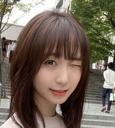

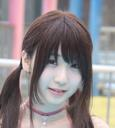

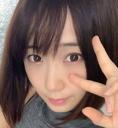

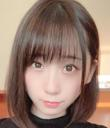

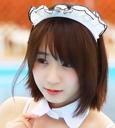

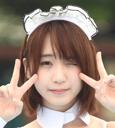

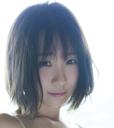

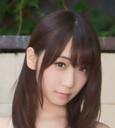

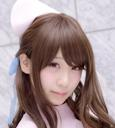

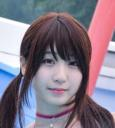

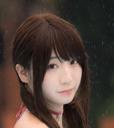

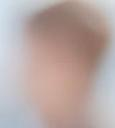

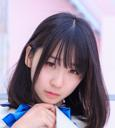

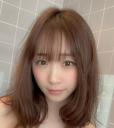

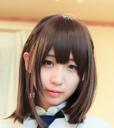

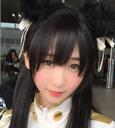

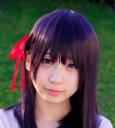

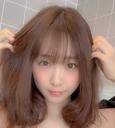

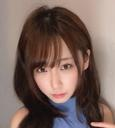

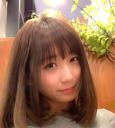

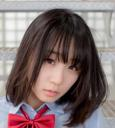

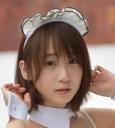

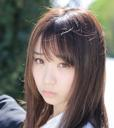

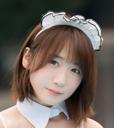

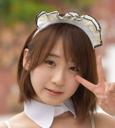

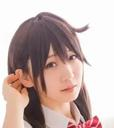

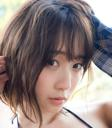

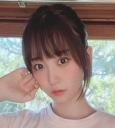

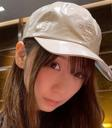

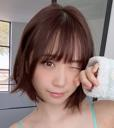

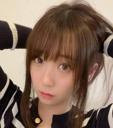

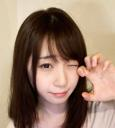

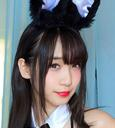

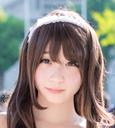

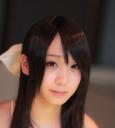

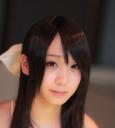

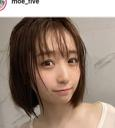

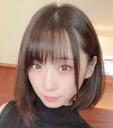

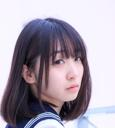

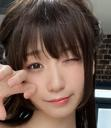

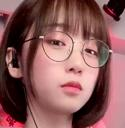

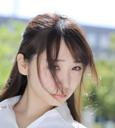

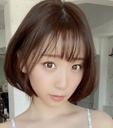

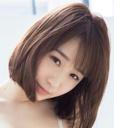

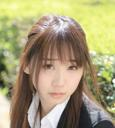

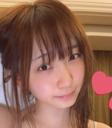

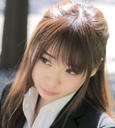

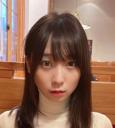

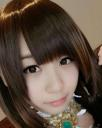

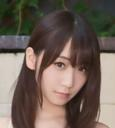

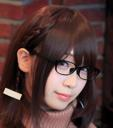

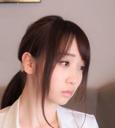

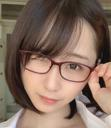

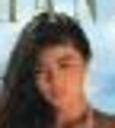

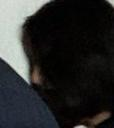

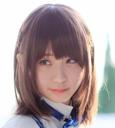

FileNotFoundError: ignored

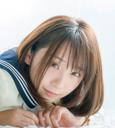

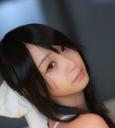

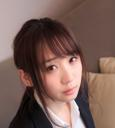

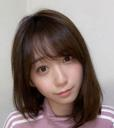

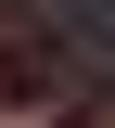

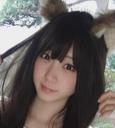

In [146]:
#for i in range (len(os.listdir('img/face_cropped/伊織もえ'))):
#  display_jpeg(Image(f'img/face_cropped/{query_string}/cropped_Image_{i}.jpg'))